# The goal of this Note Book
Based paper: https://arxiv.org/pdf/1905.04899.pdf  
**CutMix: Regularization Strategy to Train Strong Classifiers
with Localizable Features**   
본 논문의 궁극적 목적은 classifier 성능을 높이는데 있다. 
  
논문의 Introduction를 요약하면, Regional dropout strategie은 classifier의 성능을 높이는데 좋은 영향을 준다. 그래서 논문 게제 당시 주로 사용되었던 기법은 black pixels or random noise을 부분적으로 적용하였다. 이는 정보 손실과 효율성 감소로 이어진다. 이를 해결하기 위해서 CutMix라는 전력을 제안하는데, 이는 훈련 이미지와 훈련 레이블을 잘라내어 다른 훈련이미지와 훈련 레이블을 집어 넣는다.   

**가설 : CutMix으로 학습한 모델이 random noise나 Augument기법으로 학습한 모델보다 더 좋은 성능을 보일 것이다.**    
  
-> 입증 과정  
1. 데이터셋 준비 (tfds stanford_dogs)   
2. 훈련된 ResNet 50 준비  
3. 기본 데이터셋, Augument적용된 데이터 셋, Cutmix 적용된 데이터 셋, Mixup 적용된 데이터 셋으로 모델 학습시키기  
4. Train의 Loss & Accuracy 추이 확인하기  
5. Validation의 Loss & Accuracy 추이 확인하기

# Check and Setup Environment

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
!nvidia-smi

Thu Nov  9 07:35:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Data 
## 1.1 Load Data

In [35]:
(ds_train), ds_train_info = tfds.load(
    'stanford_dogs',
    split='train',
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

(ds_test), ds_test_info = tfds.load(
    'stanford_dogs',
    split='test',
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

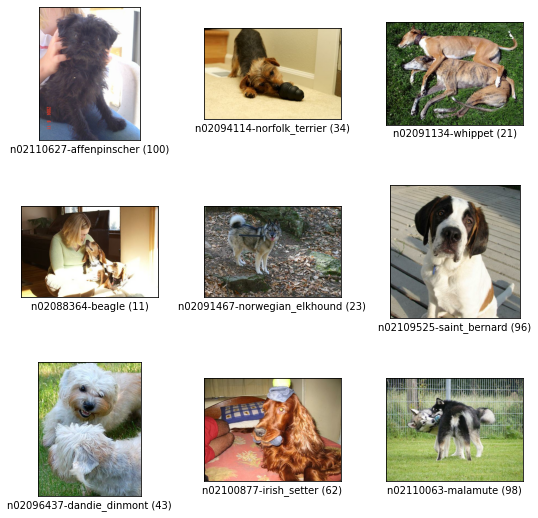

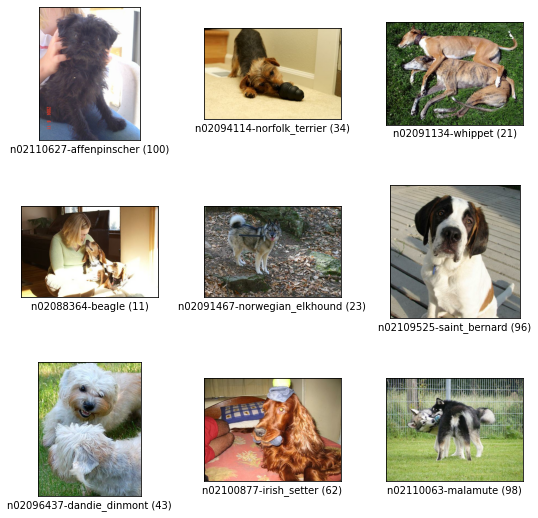

In [36]:
tfds.show_examples(ds_train, ds_train_info)

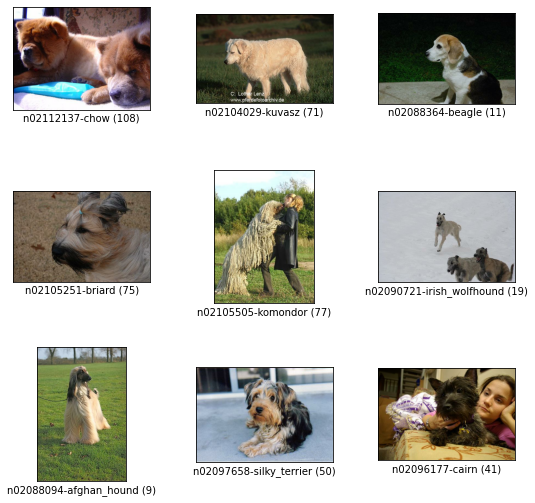

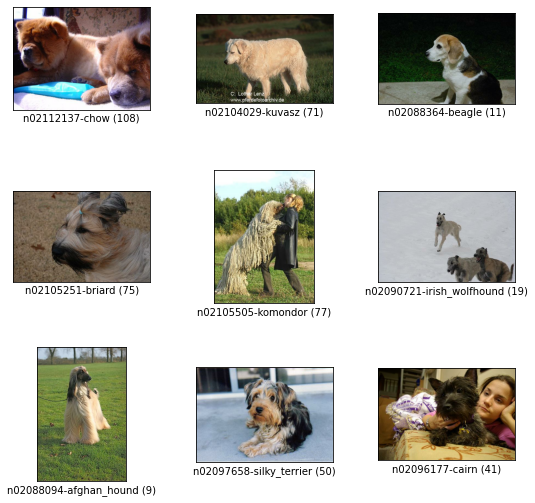

In [19]:
tfds.show_examples(ds_test, ds_test_info)

## 1-2. Data preprocessing

In [37]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

In [38]:
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [39]:
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [40]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [41]:
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [42]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [43]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 225., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [44]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16,
                               with_aug=False,
                               with_cutmix=False,
                               with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
        ds = ds.map(
            onehot
        )
    ds = ds.batch(batch_size)

    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )

    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )

    if is_test:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [45]:
ds_train_no_aug_no_cutmix_no_mixup = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug_no_cutmix_no_mixup = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_no_aug_cutmix_no_mixup = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=True)
ds_train_no_aug_no_cutmix_mixup = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=False, with_mixup=True)

In [ ]:
num_classes = ds_train_info.features["label"].num_classes
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

# 3. Model
## 3.1 Load pertrained Resnet50 (DS: imagenet)

In [47]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [48]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

## 3.2 Train Classifier

### 3.2.1 Original Dataset
- Model weight: model/resnet50_epoch20_no_aug_no_cutmix_no_mixup.keras  
- History: model/history_resnet50_no_aug_dict

In [25]:
from keras.callbacks import ModelCheckpoint
import json

EPOCH = 20

model_checkpoint = ModelCheckpoint(
    filepath="model/resnet50_epoch20_no_aug_no_cutmix_no_mixup.keras",
    save_best_only=True,
    monitor="val_loss"
)

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [26]:
resnet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________


In [27]:
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug_no_cutmix_no_mixup,
    callbacks=model_checkpoint,
    steps_per_epoch=int(ds_train_info.splits['train'].num_examples/16),
    validation_steps=int(ds_test_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


history_resnet50_no_aug_dict = history_resnet50_no_aug.history
json.dump(history_resnet50_no_aug_dict, open("model/history_resnet50_no_aug_dict", 'w'))

Epoch 1/20
750/750 [==============================] - 163s 202ms/step - loss: 2.2153 - accuracy: 0.4494 - val_loss: 3.1790 - val_accuracy: 0.2457


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
750/750 [==============================] - 150s 200ms/step - loss: 0.7701 - accuracy: 0.7821 - val_loss: 1.1301 - val_accuracy: 0.6725
Epoch 3/20
750/750 [==============================] - 150s 200ms/step - loss: 0.2404 - accuracy: 0.9501 - val_loss: 0.9876 - val_accuracy: 0.7128
Epoch 4/20
750/750 [==============================] - 150s 200ms/step - loss: 0.0653 - accuracy: 0.9942 - val_loss: 0.9198 - val_accuracy: 0.7334
Epoch 5/20
750/750 [==============================] - 150s 199ms/step - loss: 0.0288 - accuracy: 0.9989 - val_loss: 0.9311 - val_accuracy: 0.7329
Epoch 6/20
750/750 [==============================] - 150s 200ms/step - loss: 0.0181 - accuracy: 0.9994 - val_loss: 0.9347 - val_accuracy: 0.7386
Epoch 7/20
750/750 [==============================] - 150s 199ms/step - loss: 0.0133 - accuracy: 0.9997 - val_loss: 0.9471 - val_accuracy: 0.7380
Epoch 8/20
750/750 [==============================] - 150s 200ms/step - loss: 0.0097 - accuracy: 0.9998 - val_loss: 0.9619 -

### 3.2.2 Augmented Dataset
- Model weight: model/resnet50_epoch20_aug_no_cutmix_no_mixup.h5  
- History: model/history_resnet50_with_mixup_dict  
- Train Environment: Trained at Colab

```python
from keras.callbacks import ModelCheckpoint
import json

EPOCH = 20

model_checkpoint = ModelCheckpoint(
    filepath="resnet50_epoch20_yes_aug_no_cutmix_no_mixup.h5",
    save_best_only=True,
    monitor="val_loss"
)

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_yes_aug = resnet50.fit(
    ds_train_aug_no_cutmix_no_mixup,
    callbacks=model_checkpoint,
    steps_per_epoch=int(ds_train_info.splits['train'].num_examples/16),
    validation_steps=int(ds_test_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


history_resnet50_yes_aug_dict = history_resnet50_yes_aug.history
json.dump(history_resnet50_yes_aug_dict, open("history_resnet50_yes_aug_dict", 'w'))
```
![img1](./asset/img1.png)

### 3.2.4 Mixed up Dataset
- Model weight: model/resnet50_epoch20_no_aug_no_cutmix_with_mixup.keras  
- History: model/history_resnet50_with_mixup_dict

In [51]:
model_checkpoint = ModelCheckpoint(
    filepath="model/resnet50_epoch20_no_aug_no_cutmix_with_mixup.keras",
    save_best_only=True,
    monitor="val_loss"
)

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_with_mixup = resnet50.fit(
    ds_train_no_aug_no_cutmix_mixup,
    callbacks=model_checkpoint,
    steps_per_epoch=int(ds_train_info.splits['train'].num_examples/16),
    validation_steps=int(ds_test_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


history_resnet50_with_mixup_dict = history_resnet50_with_mixup.history
json.dump(history_resnet50_with_mixup_dict, open("model/history_resnet50_with_mixup_dict", 'w'))

Epoch 1/20
750/750 [==============================] - 161s 204ms/step - loss: 3.7368 - accuracy: 0.2349 - val_loss: 4.0950 - val_accuracy: 0.1199


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
750/750 [==============================] - 167s 222ms/step - loss: 2.8670 - accuracy: 0.4733 - val_loss: 1.5537 - val_accuracy: 0.5642
Epoch 3/20
750/750 [==============================] - 151s 202ms/step - loss: 2.5758 - accuracy: 0.5827 - val_loss: 1.3649 - val_accuracy: 0.6300
Epoch 4/20
750/750 [==============================] - 167s 222ms/step - loss: 2.3866 - accuracy: 0.6590 - val_loss: 1.2805 - val_accuracy: 0.6438
Epoch 5/20
750/750 [==============================] - 151s 202ms/step - loss: 2.2712 - accuracy: 0.6994 - val_loss: 1.2821 - val_accuracy: 0.6476
Epoch 6/20
750/750 [==============================] - 167s 222ms/step - loss: 2.1515 - accuracy: 0.7473 - val_loss: 1.2393 - val_accuracy: 0.6588
Epoch 7/20
750/750 [==============================] - 151s 202ms/step - loss: 2.0847 - accuracy: 0.7740 - val_loss: 1.2670 - val_accuracy: 0.6557
Epoch 8/20
750/750 [==============================] - 151s 201ms/step - loss: 2.0147 - accuracy: 0.7950 - val_loss: 1.3022 -

In [ ]:
import matplotlib.pyplot as plt
import json


with open("model/history_resnet50_no_aug_dict", "r") as file:
    history_no_aug_dict = json.load(file)
    
with open("model/history_resnet50_with_mixup_dict", "r") as file:
    history_with_mixup_dict = json.load(file)


accuracy_no_aug = history_no_aug_dict["accuracy"]
val_accuracy_no_aug = history_no_aug_dict["val_accuracy"]
loss_no_aug = history_no_aug_dict["loss"]
val_loss_no_aug = history_no_aug_dict["val_loss"]

accuracy_with_mixup = history_with_mixup_dict["accuracy"]
val_accuracy_with_mixup = history_with_mixup_dict["val_accuracy"]
loss_with_mixup = history_with_mixup_dict["loss"]
val_loss_with_mixup = history_with_mixup_dict0["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy_res34, "bo", label="ResNet34 Training accuracy")
plt.plot(epochs, val_accuracy_res34, "b", label="ResNet34 Validation accuracy")
plt.plot(epochs, accuracy_res50, "ro", label="ResNet50 Training accuracy")
plt.plot(epochs, val_accuracy_res50, "r", label="ResNet50 Validation accuracy")
plt.title("ResNet34 VS ResNet50")
plt.legend()
plt.figure()

# 회고

1. Project 병렬적으로 돌리도록 스크립트를 짜자. (LMS, Colab, local 환경에서 돌려 결과만 합치자)  
2. data의 shape을 항상 세심하게 체크하자 (예를 들어 sparse categorical_crossentropy와 categorical_crossentropy 차이를 구별 & Batch size에 결정 되는 steps_per_epoch을 고려하자